<a href="https://colab.research.google.com/github/youssef893/Arabic-Entity-Recognition/blob/main/Arabic_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all needed libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer

In [ ]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import word2vec

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Flatten, Reshape
from keras import Input
from keras.models import Model

In [ ]:
import nltk
nltk.download('stopwords')
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
arabic_stop_word = stopwords.words('arabic')
stemmer = ISRIStemmer()

# Utilz

In [ ]:
def token_preprocessing(token):
  """
  parameter: 
    token: string contain word

    return: 
      token: the word after removing preffix and suffix (get the original word)
      true: if it is not a stop word
  """
  is_arabic = bool(re.match('^[أ-ي]', token))
  if token not in arabic_stop_word and is_arabic:
    token = stemmer.stem(token)
    return token, False
  
  return token, True
  

In [ ]:
def is_txt(file):
  """
    return true if this file extention

    parameters:
      file: string contains the full name of this file 
  """
  return file.split('.')[-1] == "txt"

In [ ]:
def get_sentences(file):
    """
    Parameters:
      file: string contains the full name of this file 


    Returns:
      sentences: array contains all sentences exist in this txt file
    """
  

    sentences = []

    with open(file) as f:
      lines = f.readlines()

    sentence = ""
    for line in lines:
      line = line.replace('.', '').split()
      if len(line) == 0: # then current line contains '.' or ','
        sentences.append(sentence)
        sentence = "" 
      else :
        sentence += f'{line[0]} '

    return sentences

    


In [ ]:
def get_tokens_labels_dict(file ):

    """
    adds new tokens and its labels to current train dictionary 

    Parameters:
      file: string contains the full name of this file 


    Returns:
      tokens: string of all sentences in the file
      labels: string of all labels
    """

    tokens = ''
    labels = ''

    with open(file) as f:
      lines = f.readlines()

    for line in lines:

      if len( line.split() ) == 0: # then current line is \n
        continue
      
      token , label = line.split()
      

      if token != '.':
        token, is_stopword = token_preprocessing(token)

        if is_stopword:
          continue
        
        tokens += token + ' '
        labels += label + ' '
      
    return tokens, labels


## Loading Data

In [ ]:
from zipfile import ZipFile

with ZipFile('/content/AQMAR_Arabic_NER_corpus-1.0.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('AQMAR')
   print('File is unzipped in AQMAR folder') 

File is unzipped in AQMAR folder


In [ ]:
data_folder = "/content/AQMAR"
files = sorted(os.listdir(data_folder))

In [ ]:
for i , file in enumerate(files):
    print(f'i = {i+1} | File = {file}')
    
print(f'\nExample For A Full Path {data_folder}/{file}')

i = 1 | File = Atom.txt
i = 2 | File = Christiano_Ronaldo.txt
i = 3 | File = Computer.txt
i = 4 | File = Computer_Software.txt
i = 5 | File = Crusades.txt
i = 6 | File = Damascus.txt
i = 7 | File = Enrico_Fermi.txt
i = 8 | File = Football.txt
i = 9 | File = Ibn_Tolun_Mosque.txt
i = 10 | File = Imam_Hussein_Shrine.txt
i = 11 | File = Internet.txt
i = 12 | File = Islamic_Golden_Age.txt
i = 13 | File = Islamic_History.txt
i = 14 | File = LICENSE
i = 15 | File = Light.txt
i = 16 | File = Linux.txt
i = 17 | File = Nuclear_Power.txt
i = 18 | File = Periodic_Table.txt
i = 19 | File = Physics.txt
i = 20 | File = Portugal_football_team.txt
i = 21 | File = README
i = 22 | File = Raul_Gonzales.txt
i = 23 | File = Razi.txt
i = 24 | File = Real_Madrid.txt
i = 25 | File = Richard_Stallman.txt
i = 26 | File = Soccer_Worldcup.txt
i = 27 | File = Solaris.txt
i = 28 | File = Summer_Olympics2004.txt
i = 29 | File = Ummaya_Mosque.txt
i = 30 | File = VERSION
i = 31 | File = X_window_system.txt
i = 32 | Fil

In [ ]:
txt_files = []
for i , file in enumerate(files):
    if is_txt(file):
      txt_files.append(f'{data_folder}/{file}')

In [ ]:
txt_files

['/content/AQMAR/Atom.txt',
 '/content/AQMAR/Christiano_Ronaldo.txt',
 '/content/AQMAR/Computer.txt',
 '/content/AQMAR/Computer_Software.txt',
 '/content/AQMAR/Crusades.txt',
 '/content/AQMAR/Damascus.txt',
 '/content/AQMAR/Enrico_Fermi.txt',
 '/content/AQMAR/Football.txt',
 '/content/AQMAR/Ibn_Tolun_Mosque.txt',
 '/content/AQMAR/Imam_Hussein_Shrine.txt',
 '/content/AQMAR/Internet.txt',
 '/content/AQMAR/Islamic_Golden_Age.txt',
 '/content/AQMAR/Islamic_History.txt',
 '/content/AQMAR/Light.txt',
 '/content/AQMAR/Linux.txt',
 '/content/AQMAR/Nuclear_Power.txt',
 '/content/AQMAR/Periodic_Table.txt',
 '/content/AQMAR/Physics.txt',
 '/content/AQMAR/Portugal_football_team.txt',
 '/content/AQMAR/Raul_Gonzales.txt',
 '/content/AQMAR/Razi.txt',
 '/content/AQMAR/Real_Madrid.txt',
 '/content/AQMAR/Richard_Stallman.txt',
 '/content/AQMAR/Soccer_Worldcup.txt',
 '/content/AQMAR/Solaris.txt',
 '/content/AQMAR/Summer_Olympics2004.txt',
 '/content/AQMAR/Ummaya_Mosque.txt',
 '/content/AQMAR/X_window_sys

In [ ]:
""" loop over all files to get their sentences and labels then store them in 2 strings """
tokens = ''
labels = ''
for txt_file in txt_files:
  data, data_labels = get_tokens_labels_dict(txt_file)
  
  tokens += data
  labels += data_labels


In [ ]:
""" split strings into lists of words and labels """
tokens = tokens.split(' ')
labels = labels.split(' ')

128941


47540

In [ ]:
""" get all words and length of labels """
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokens)
output_length = len(set(labels))

In [ ]:
tokens[1]

'صغر'

In [ ]:
""" reshape data into sentences of 10 words and list of each word label """
tokens = np.array(tokens)
tokens = tokens.reshape(4754, 10)
labels = np.array(labels).reshape(4754, 10)

In [ ]:
print(len(tokens), len(labels))

4754 4754


In [ ]:
tokens.shape

(4754, 10)

In [ ]:
print(f'First Token is {tokens[0]} And Its label is {labels[0]}')
len(tokens) == len(labels)

First Token is ['ذرة' 'صغر' 'جزء' 'عنصر' 'كيميائ' 'حفظ' 'خصص' 'كيميائية' 'لذلك' 'عنصر'] And Its label is ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']


True

# **PREPARING DATA**

In [ ]:
def check_duplicate(token):
  """ 
    parameters:
      token: sentence to check words in it is unique or not
      
    return:
      is_unique: return if all words all unique and there is no duplicates
      length_difference: return difference between them to get number of duplicates
  """
  token_set = set(token)
  is_unique = len(token_set) != len(token) 
  length_difference = len(token) - len(token_set)
  return is_unique, length_difference 

Prepare data to model by encoding it into integers and one hot encoding then makes sequence from text 


In [ ]:
from keras.utils.control_flow_util import constant_value
def encode_text(tokens):
  """
    Parameters:
      tokens: it is the all word

    Return:
      tokens: after encoding it using one hot encoder
    """
  encoded_tokens = []
  for token, i in zip(tokens, range(len(tokens))):
    is_duplicated, length_difference =  check_duplicate(token)
    token = np.array(token)
    onehot_encoder = OneHotEncoder(sparse=False)
    token = token.reshape(-1, 1)
    token = onehot_encoder.fit_transform(token)

    if is_duplicated:
      # add zeros to token to make all shapes equal (10, 10)
      # because one hot encoding did not calculate duplicates 
      # l = ['a', 'b', 'a'] ==> encoded_l = ['01', '10', '01']
      # not encode it by its length
      token = np.concatenate((token , np.zeros((10,length_difference), dtype=int)), axis=1)

    encoded_tokens.append(token)
  return np.array(encoded_tokens)

In [ ]:
tokens = encode_text(tokens)

In [ ]:
tokens[0]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [ ]:
""" one hot encoder for labels """
labels = np.array(labels)
onehot_encoder = OneHotEncoder(sparse=False)
labels = labels.reshape(-1, 1)
labels = onehot_encoder.fit_transform(labels)

In [ ]:
labels.shape

(47540, 23)

In [ ]:
""" reshape to tokens shape """
labels = labels.reshape(4754, 10, 23)

Splite data into train, validation and test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tokens, labels, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Recognition Model

Download pretrained word2vec model for arabic ===> aravec model

In [ ]:
""" Both of them give same accuracy """
# !wget https://archive.org/download/aravec2.0/tweet_cbow_300.zip  # This is model which train on 132,750,000 documents
# !wget https://archive.org/download/aravec2.0/www_cbow_300.zip  # This is model which train on 66,900,000 documents 

' Both of them give same accuracy '

In [ ]:
# !unzip -q tweet_cbow_300  

# !unzip -q www_cbow_300   ==> model was used


In [ ]:
aravec_embeddings_index = {}
TOTAL_EMBEDDING_DIM = 300
embeddings_model_path = '/content/www_cbow_300'

aravec_model = KeyedVectors.load(embeddings_model_path)  # load word2vec model
# loop to getting values of words
for word in aravec_model.wv.vocab:
   aravec_embeddings_index[word] = aravec_model[word]

print('Loaded %s word vectors.'% len(aravec_embeddings_index))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Loaded 234961 word vectors.


In [ ]:
# create a weight matrix for words in training docs
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, TOTAL_EMBEDDING_DIM))
print(tokenizer.word_index.items(), tokenizer.word_index)
for word, i in tokenizer.word_index.items():
    embedding_vector = aravec_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print('Embedding Matrix shape:', embedding_matrix.shape)

In [ ]:
# load embedding layer and set it's weights
embedding_layer = Embedding(vocab_size, TOTAL_EMBEDDING_DIM, weights=[embedding_matrix], input_length=10, trainable=False)

In [ ]:
# define model
input_placeholder = Input(shape=(10, 10))
input_embedding = embedding_layer(input_placeholder)
# reshape data to make many to many model and setting lstm to get multiple inputs
inner = Reshape(target_shape=((10, 3000)), name='reshape1')(input_embedding)
lstm = LSTM(units=10, input_shape=(10, 3000), return_sequences=True, activation='tanh', name='lstm1')(inner)
output = Dense(23, activation='sigmoid', name = 'activation')(lstm)

model = Model(inputs=input_placeholder, outputs=output)

In [ ]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adamax(lr=0.001), metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 10, 10)]          0         
                                                                 
 embedding_16 (Embedding)    (None, 10, 10, 300)       1538700   
                                                                 
 reshape1 (Reshape)          (None, 10, 3000)          0         
                                                                 
 lstm1 (LSTM)                (None, 10, 10)            120440    
                                                                 
 activation (Dense)          (None, 10, 23)            253       
                                                                 
Total params: 1,659,393
Trainable params: 120,693
Non-trainable params: 1,538,700
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=20, verbose=1)

Epoch 1/20
96/96 [==============================] - 5s 28ms/step - loss: 0.5149 - accuracy: 0.7327 - val_loss: 0.3754 - val_accuracy: 0.8338
Epoch 2/20
96/96 [==============================] - 2s 22ms/step - loss: 0.2958 - accuracy: 0.8335 - val_loss: 0.2301 - val_accuracy: 0.8338
Epoch 3/20
96/96 [==============================] - 2s 21ms/step - loss: 0.1916 - accuracy: 0.8335 - val_loss: 0.1605 - val_accuracy: 0.8338
Epoch 4/20
96/96 [==============================] - 2s 22ms/step - loss: 0.1421 - accuracy: 0.8335 - val_loss: 0.1262 - val_accuracy: 0.8338
Epoch 5/20
96/96 [==============================] - 2s 21ms/step - loss: 0.1159 - accuracy: 0.8335 - val_loss: 0.1065 - val_accuracy: 0.8338
Epoch 6/20
96/96 [==============================] - 2s 22ms/step - loss: 0.1001 - accuracy: 0.8335 - val_loss: 0.0940 - val_accuracy: 0.8338
Epoch 7/20
96/96 [==============================] - 2s 22ms/step - loss: 0.0898 - accuracy: 0.8335 - val_loss: 0.0856 - val_accuracy: 0.8338
Epoch 8/20
96

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
prediction = model.predict(x_test)
print('Accuracy: %f' % (accuracy*100), loss)

Accuracy: 84.258676 0.057846784591674805


In [ ]:
predicted_indixes, true_indcies = [], []
for i, j in zip(prediction, y_test):
  predicted_indixes.append(np.argmax(i))
  true_indcies.append(np.argmax(j))

# Plot Confusion Matrix

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
cf_matrix = confusion_matrix(predicted_indixes, true_indcies)

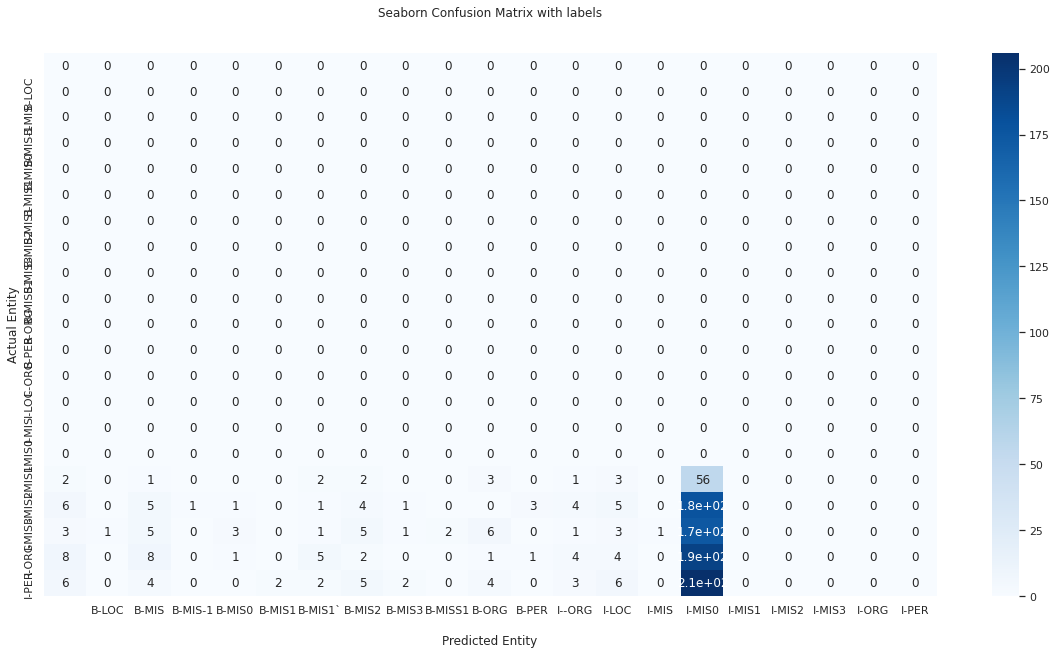

In [ ]:
sns.set(rc = {'figure.figsize':(20, 10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title(f'Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Entity')
ax.set_ylabel('Actual Entity')
# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['',
 'B-LOC',
 'B-MIS',
 'B-MIS-1',
 'B-MIS0',
 'B-MIS1',
 'B-MIS1`',
 'B-MIS2',
 'B-MIS3',
 'B-MISS1',
 'B-ORG',
 'B-PER',
 'I--ORG',
 'I-LOC',
 'I-MIS',
 'I-MIS0',
 'I-MIS1',
 'I-MIS2',
 'I-MIS3',
 'I-ORG',
 'I-PER',
 'IO',
 'O'])
ax.yaxis.set_ticklabels(['',
 'B-LOC',
 'B-MIS',
 'B-MIS-1',
 'B-MIS0',
 'B-MIS1',
 'B-MIS1`',
 'B-MIS2',
 'B-MIS3',
 'B-MISS1',
 'B-ORG',
 'B-PER',
 'I--ORG',
 'I-LOC',
 'I-MIS',
 'I-MIS0',
 'I-MIS1',
 'I-MIS2',
 'I-MIS3',
 'I-ORG',
 'I-PER',
 'IO',
 'O'])
# Display the visualization of the Confusion Matrix.
plt.show()

# Plot Fitting

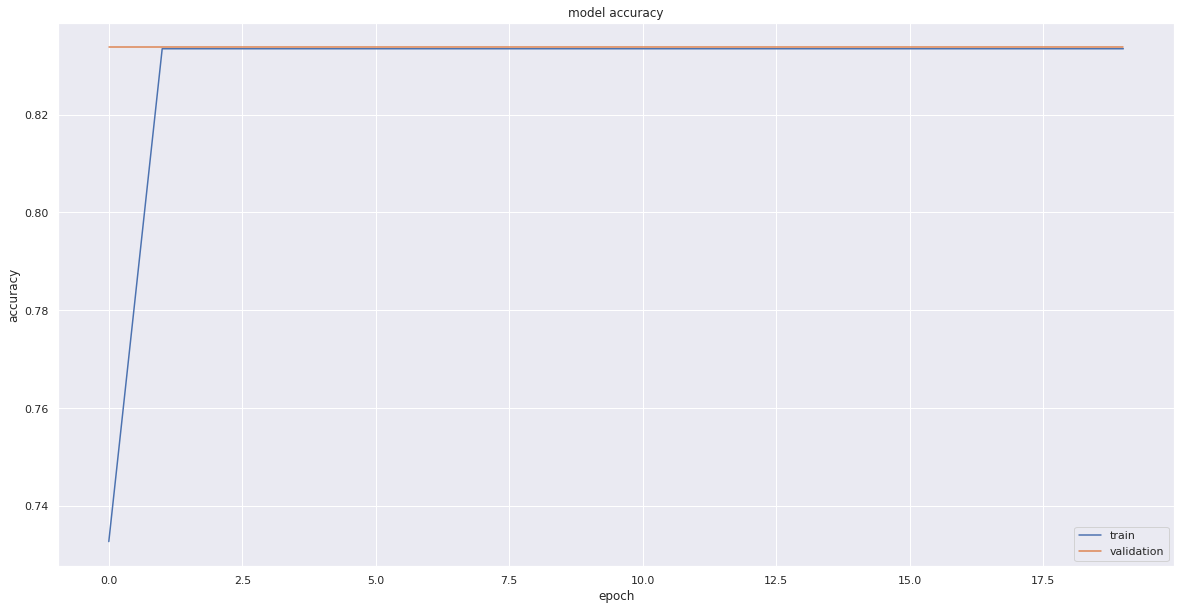

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

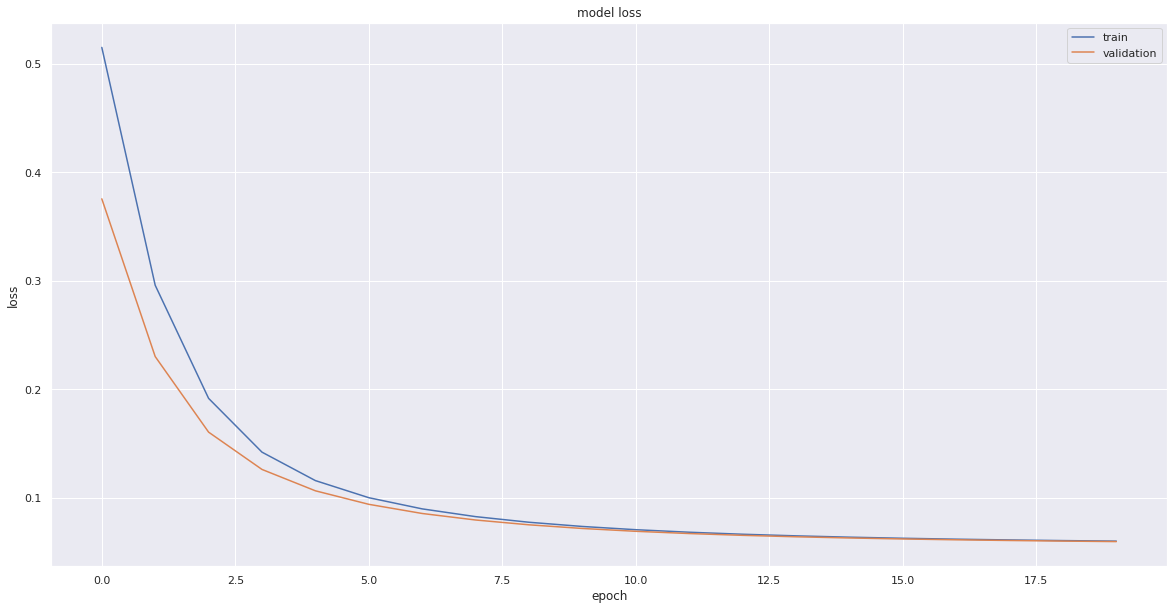

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
labels = ['',
 'B-LOC',
 'B-MIS',
 'B-MIS-1',
 'B-MIS0',
 'B-MIS1',
 'B-MIS1`',
 'B-MIS2',
 'B-MIS3',
 'B-MISS1',
 'B-ORG',
 'B-PER',
 'I--ORG',
 'I-LOC',
 'I-MIS',
 'I-MIS0',
 'I-MIS1',
 'I-MIS2',
 'I-MIS3',
 'I-ORG',
 'I-PER',
 'IO',
 'O']

In [ ]:
def encode(token):
  """ encode test text """
  is_duplicated, length_difference =  check_duplicate(token)
  token = np.array(token)
  onehot_encoder = OneHotEncoder(sparse=False)
  token = token.reshape(-1, 1)
  token = onehot_encoder.fit_transform(token)
  
  return token

In [ ]:
text = 'منتخب مصر الأكثر تتويجا فى قارة افريقيا بقيادة حسن شحاتة'
text = text.split()
test_text = []

for word in text:
  word, is_stop_word = token_preprocessing(word)
  
  if not is_stop_word:
    test_text.append(word)
# prepate test text to model
test_text = encode(test_text)
test_text = test_text.reshape(1, 10, 10)
prediction = model.predict(test_text)
for i in range(len(prediction[0])):
  index = prediction[0][i].argmax()
  print(labels[index])

نخب
مصر
كثر
توج
فى
قرة
فرق
قيد
حسن
شحت
O
O
O
O
O
O
O
O
O
O
